In [ ]:

!pip install gdown timm

import gdown
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import timm
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Download and extract dataset
file_id = '1jsMUDlvsXWQu2BansJz73mAErVyNg_g7'
destination = '/content/shared_file.zip'
gdown.download(id=file_id, output=destination, quiet=False)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 21.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

Downloading...
From (original): https://drive.google.com/uc?id=1jsMUDlvsXWQu2BansJz73mAErVyNg_g7
From (redirected): https://drive.google.com/uc?id=1jsMUDlvsXWQu2BansJz73mAErVyNg_g7&confirm=t&uuid=e4ec9532-93fd-47a1-8079-986af05e9a02
To: /content/shared_file.zip
100%|██████████| 1.46G/1.46G [00:17<00:00, 83.8MB/s]


'/content/shared_file.zip'

In [ ]:

# Check if the file is indeed a ZIP file
zip_path = '/content/shared_file.zip'

try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        print("ZIP file opened successfully.")
        zip_ref.extractall('/content')
    print("Extraction complete.")
except zipfile.BadZipFile:
    print("Error: The file is not a valid ZIP file or it is corrupted.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


ZIP file opened successfully.
Extraction complete.


In [ ]:

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define constants
data_dirs = {
    'train': ["l0", "l1", "l2"],
    'test': ["l0", "l1", "l2"]
}
data_root = "/content/T4_Pdata"  # Replace with the root directory of your data

# Create a list to store the paths and labels of all images
train_data = []
test_data = []

# Populate the list with paths and labels
for phase in data_dirs:
    for label, folder in enumerate(data_dirs[phase]):
        folder_path = os.path.join(data_root, phase, folder)
        image_files = os.listdir(folder_path)
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            if phase == 'train':
                train_data.append((image_path, label))
            else:
                test_data.append((image_path, label))

# Split train_data into training and validation sets while maintaining class distribution
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=[label for _, label in train_data])

# Define custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert('RGB')  # Open image and convert to RGB mode
        if self.transform:
            img = self.transform(img)
        label_tensor = torch.tensor(label, dtype=torch.long)  # Convert label to tensor
        return img, label_tensor

# Image preprocessing with augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

# Image preprocessing without augmentation for testing and validation
test_val_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor()
])


Using device: cuda


In [ ]:

# Create custom datasets
train_dataset = CustomDataset(train_data, transform=train_transform)
val_dataset = CustomDataset(val_data, transform=test_val_transform)
test_dataset = CustomDataset(test_data, transform=test_val_transform)

# DataLoaders for batching and shuffling
batch_size = 32  # Define the batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Use DenseNet121 model
model = timm.create_model("hf_hub:timm/densenet121.ra_in1k", pretrained=True)

# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# Modify the final layer to match the number of classes in the dataset
num_classes = len(data_dirs['train'])
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

model.to(device)  # Move model to GPU

# Define optimizer and scheduler
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)  # Set learning rate to 10^-3

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=1e-6)  # Reduce factor, patience, and lower bound for LR

# Define loss function
criterion = nn.CrossEntropyLoss()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/668 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:

# Train the model
num_epochs = 100  # Set number of epochs to 100

# Lists to store training and validation losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Train the model
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        # Ensure the input tensor is passed correctly
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        progress_bar.set_postfix({'Loss': train_loss / total, 'Accuracy': 100 * correct / total})

    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # Adjust learning rate
    scheduler.step(val_loss)


Epoch 1/100, Train Loss: 0.8405, Train Accuracy: 60.81%, Val Loss: 1.0156, Val Accuracy: 52.55%


Epoch 2/100, Train Loss: 0.7256, Train Accuracy: 66.63%, Val Loss: 0.7195, Val Accuracy: 70.54%


Epoch 3/100, Train Loss: 0.6316, Train Accuracy: 72.17%, Val Loss: 1.4975, Val Accuracy: 56.85%


Epoch 4/100, Train Loss: 0.6164, Train Accuracy: 73.01%, Val Loss: 0.9674, Val Accuracy: 60.03%


Epoch 5/100, Train Loss: 0.5868, Train Accuracy: 75.04%, Val Loss: 0.6440, Val Accuracy: 71.66%


Epoch 6/100, Train Loss: 0.5239, Train Accuracy: 77.55%, Val Loss: 0.5912, Val Accuracy: 72.93%


Epoch 7/100, Train Loss: 0.4858, Train Accuracy: 79.51%, Val Loss: 1.1515, Val Accuracy: 54.30%


Epoch 8/100, Train Loss: 0.4888, Train Accuracy: 79.39%, Val Loss: 0.9869, Val Accuracy: 61.62%


Epoch 9/100, Train Loss: 0.4464, Train Accuracy: 81.06%, Val Loss: 0.7096, Val Accuracy: 70.38%


Epoch 10/100, Train Loss: 0.4189, Train Accuracy: 82.93%, Val Loss: 0.6357, Val Accuracy: 75.80%


Epoch 11/100, Train Loss: 0.4179, Train Accuracy: 83.13%, Val Loss: 0.6467, Val Accuracy: 67.68%


Epoch 12/100, Train Loss: 0.3764, Train Accuracy: 84.77%, Val Loss: 0.7187, Val Accuracy: 66.56%


Epoch 13/100, Train Loss: 0.3942, Train Accuracy: 83.77%, Val Loss: 0.6594, Val Accuracy: 73.73%


Epoch 14/100, Train Loss: 0.3451, Train Accuracy: 86.60%, Val Loss: 0.7222, Val Accuracy: 67.36%


Epoch 15/100, Train Loss: 0.3487, Train Accuracy: 85.61%, Val Loss: 1.5525, Val Accuracy: 61.15%


Epoch 16/100, Train Loss: 0.3356, Train Accuracy: 86.16%, Val Loss: 1.0102, Val Accuracy: 64.81%


Epoch 17/100, Train Loss: 0.3230, Train Accuracy: 86.72%, Val Loss: 0.5329, Val Accuracy: 77.23%


Epoch 18/100, Train Loss: 0.3101, Train Accuracy: 87.80%, Val Loss: 0.6192, Val Accuracy: 75.32%


Epoch 19/100, Train Loss: 0.3082, Train Accuracy: 87.92%, Val Loss: 0.5915, Val Accuracy: 76.11%


Epoch 20/100, Train Loss: 0.2845, Train Accuracy: 88.08%, Val Loss: 0.5571, Val Accuracy: 79.46%


Epoch 21/100, Train Loss: 0.2931, Train Accuracy: 87.76%, Val Loss: 1.2315, Val Accuracy: 62.10%


Epoch 22/100, Train Loss: 0.2673, Train Accuracy: 89.11%, Val Loss: 0.5176, Val Accuracy: 82.64%


Epoch 23/100, Train Loss: 0.3008, Train Accuracy: 87.60%, Val Loss: 0.5894, Val Accuracy: 77.55%


Epoch 24/100, Train Loss: 0.2617, Train Accuracy: 89.95%, Val Loss: 0.5324, Val Accuracy: 77.71%


Epoch 25/100, Train Loss: 0.2281, Train Accuracy: 91.11%, Val Loss: 0.4097, Val Accuracy: 84.87%


Epoch 26/100, Train Loss: 0.2147, Train Accuracy: 91.27%, Val Loss: 0.6091, Val Accuracy: 75.48%


Epoch 27/100, Train Loss: 0.2547, Train Accuracy: 90.39%, Val Loss: 0.5147, Val Accuracy: 78.18%


Epoch 28/100, Train Loss: 0.2539, Train Accuracy: 90.35%, Val Loss: 0.4229, Val Accuracy: 83.60%


Epoch 29/100, Train Loss: 0.2218, Train Accuracy: 91.75%, Val Loss: 0.4310, Val Accuracy: 83.60%


Epoch 30/100, Train Loss: 0.2018, Train Accuracy: 91.63%, Val Loss: 0.5344, Val Accuracy: 80.57%


Epoch 31/100, Train Loss: 0.2130, Train Accuracy: 91.83%, Val Loss: 0.6430, Val Accuracy: 78.66%


Epoch 32/100, Train Loss: 0.1934, Train Accuracy: 92.82%, Val Loss: 0.4616, Val Accuracy: 81.85%


Epoch 33/100, Train Loss: 0.1956, Train Accuracy: 92.34%, Val Loss: 0.7321, Val Accuracy: 73.89%


Epoch 34/100, Train Loss: 0.2077, Train Accuracy: 91.83%, Val Loss: 0.7514, Val Accuracy: 75.64%


Epoch 35/100, Train Loss: 0.1570, Train Accuracy: 94.38%, Val Loss: 0.5220, Val Accuracy: 79.78%


Epoch 36/100, Train Loss: 0.1792, Train Accuracy: 93.86%, Val Loss: 0.8942, Val Accuracy: 68.95%


Epoch 37/100, Train Loss: 0.1389, Train Accuracy: 94.78%, Val Loss: 0.4147, Val Accuracy: 86.62%


Epoch 38/100, Train Loss: 0.1053, Train Accuracy: 96.49%, Val Loss: 0.4159, Val Accuracy: 86.62%


Epoch 39/100, Train Loss: 0.0876, Train Accuracy: 96.93%, Val Loss: 0.3740, Val Accuracy: 88.69%


Epoch 40/100, Train Loss: 0.0926, Train Accuracy: 96.89%, Val Loss: 0.3917, Val Accuracy: 88.54%


Epoch 41/100, Train Loss: 0.0796, Train Accuracy: 97.33%, Val Loss: 0.3835, Val Accuracy: 88.69%


Epoch 42/100, Train Loss: 0.0728, Train Accuracy: 97.89%, Val Loss: 0.3965, Val Accuracy: 87.90%


Epoch 43/100, Train Loss: 0.0722, Train Accuracy: 97.57%, Val Loss: 0.4094, Val Accuracy: 88.54%


Epoch 44/100, Train Loss: 0.0654, Train Accuracy: 98.13%, Val Loss: 0.3817, Val Accuracy: 87.74%


Epoch 45/100, Train Loss: 0.0660, Train Accuracy: 97.69%, Val Loss: 0.4015, Val Accuracy: 88.69%


Epoch 46/100, Train Loss: 0.0543, Train Accuracy: 98.68%, Val Loss: 0.3914, Val Accuracy: 88.69%


Epoch 47/100, Train Loss: 0.0567, Train Accuracy: 98.29%, Val Loss: 0.3858, Val Accuracy: 88.22%


Epoch 48/100, Train Loss: 0.0564, Train Accuracy: 98.21%, Val Loss: 0.3987, Val Accuracy: 88.22%


Epoch 49/100, Train Loss: 0.0544, Train Accuracy: 98.29%, Val Loss: 0.4128, Val Accuracy: 88.22%


Epoch 50/100, Train Loss: 0.0489, Train Accuracy: 98.52%, Val Loss: 0.3840, Val Accuracy: 88.38%


Epoch 51/100, Train Loss: 0.0521, Train Accuracy: 98.25%, Val Loss: 0.3983, Val Accuracy: 87.58%


Epoch 52/100, Train Loss: 0.0465, Train Accuracy: 98.68%, Val Loss: 0.3922, Val Accuracy: 88.06%


Epoch 53/100, Train Loss: 0.0450, Train Accuracy: 98.60%, Val Loss: 0.3774, Val Accuracy: 88.54%


Epoch 54/100, Train Loss: 0.0481, Train Accuracy: 98.37%, Val Loss: 0.3930, Val Accuracy: 89.01%


Epoch 55/100, Train Loss: 0.0421, Train Accuracy: 98.76%, Val Loss: 0.3998, Val Accuracy: 88.38%


Epoch 56/100, Train Loss: 0.0442, Train Accuracy: 98.60%, Val Loss: 0.3771, Val Accuracy: 88.54%


Epoch 57/100, Train Loss: 0.0377, Train Accuracy: 98.72%, Val Loss: 0.3955, Val Accuracy: 88.06%


Epoch 58/100, Train Loss: 0.0460, Train Accuracy: 98.41%, Val Loss: 0.4030, Val Accuracy: 87.90%


Epoch 59/100, Train Loss: 0.0496, Train Accuracy: 98.33%, Val Loss: 0.3918, Val Accuracy: 88.22%


Epoch 60/100, Train Loss: 0.0490, Train Accuracy: 98.29%, Val Loss: 0.4062, Val Accuracy: 88.38%


Epoch 61/100, Train Loss: 0.0452, Train Accuracy: 98.64%, Val Loss: 0.3661, Val Accuracy: 89.49%


Epoch 62/100, Train Loss: 0.0400, Train Accuracy: 98.64%, Val Loss: 0.4106, Val Accuracy: 87.74%


Epoch 63/100, Train Loss: 0.0385, Train Accuracy: 98.76%, Val Loss: 0.3697, Val Accuracy: 89.33%


Epoch 64/100, Train Loss: 0.0420, Train Accuracy: 98.68%, Val Loss: 0.3981, Val Accuracy: 88.54%


Epoch 65/100, Train Loss: 0.0392, Train Accuracy: 98.84%, Val Loss: 0.4135, Val Accuracy: 88.22%


Epoch 66/100, Train Loss: 0.0447, Train Accuracy: 98.72%, Val Loss: 0.4066, Val Accuracy: 87.42%


Epoch 67/100, Train Loss: 0.0414, Train Accuracy: 98.60%, Val Loss: 0.4262, Val Accuracy: 87.42%


Epoch 68/100, Train Loss: 0.0426, Train Accuracy: 98.48%, Val Loss: 0.3936, Val Accuracy: 88.22%


Epoch 69/100, Train Loss: 0.0462, Train Accuracy: 98.60%, Val Loss: 0.3888, Val Accuracy: 87.90%


Epoch 70/100, Train Loss: 0.0469, Train Accuracy: 98.41%, Val Loss: 0.4063, Val Accuracy: 87.10%


Epoch 71/100, Train Loss: 0.0384, Train Accuracy: 98.84%, Val Loss: 0.4010, Val Accuracy: 88.69%


Epoch 72/100, Train Loss: 0.0417, Train Accuracy: 98.68%, Val Loss: 0.4089, Val Accuracy: 87.74%


Epoch 73/100, Train Loss: 0.0449, Train Accuracy: 98.44%, Val Loss: 0.3898, Val Accuracy: 87.90%


Epoch 74/100, Train Loss: 0.0357, Train Accuracy: 98.92%, Val Loss: 0.4225, Val Accuracy: 87.58%


Epoch 75/100, Train Loss: 0.0368, Train Accuracy: 98.96%, Val Loss: 0.4091, Val Accuracy: 87.90%


Epoch 76/100, Train Loss: 0.0365, Train Accuracy: 99.04%, Val Loss: 0.4359, Val Accuracy: 88.06%


Epoch 77/100, Train Loss: 0.0466, Train Accuracy: 98.44%, Val Loss: 0.3955, Val Accuracy: 88.54%


Epoch 78/100, Train Loss: 0.0401, Train Accuracy: 98.80%, Val Loss: 0.3810, Val Accuracy: 89.01%


Epoch 79/100, Train Loss: 0.0389, Train Accuracy: 98.88%, Val Loss: 0.4188, Val Accuracy: 87.74%


Epoch 80/100, Train Loss: 0.0335, Train Accuracy: 99.16%, Val Loss: 0.3965, Val Accuracy: 88.22%


Epoch 81/100, Train Loss: 0.0373, Train Accuracy: 98.84%, Val Loss: 0.4150, Val Accuracy: 87.74%


Epoch 82/100, Train Loss: 0.0394, Train Accuracy: 98.72%, Val Loss: 0.4087, Val Accuracy: 87.42%


Epoch 83/100, Train Loss: 0.0440, Train Accuracy: 98.76%, Val Loss: 0.3980, Val Accuracy: 88.38%


Epoch 84/100, Train Loss: 0.0357, Train Accuracy: 98.84%, Val Loss: 0.3996, Val Accuracy: 88.54%


Epoch 85/100, Train Loss: 0.0427, Train Accuracy: 98.52%, Val Loss: 0.4031, Val Accuracy: 87.74%


Epoch 86/100, Train Loss: 0.0350, Train Accuracy: 98.88%, Val Loss: 0.3801, Val Accuracy: 88.54%


Epoch 87/100, Train Loss: 0.0428, Train Accuracy: 98.72%, Val Loss: 0.4095, Val Accuracy: 87.90%


Epoch 88/100, Train Loss: 0.0375, Train Accuracy: 98.76%, Val Loss: 0.3938, Val Accuracy: 87.74%


Epoch 89/100, Train Loss: 0.0396, Train Accuracy: 98.92%, Val Loss: 0.3976, Val Accuracy: 88.38%


Epoch 90/100, Train Loss: 0.0341, Train Accuracy: 99.20%, Val Loss: 0.4223, Val Accuracy: 88.06%


Epoch 91/100, Train Loss: 0.0434, Train Accuracy: 98.44%, Val Loss: 0.4091, Val Accuracy: 88.22%


Epoch 92/100, Train Loss: 0.0441, Train Accuracy: 98.56%, Val Loss: 0.4030, Val Accuracy: 88.06%


Epoch 93/100, Train Loss: 0.0391, Train Accuracy: 98.56%, Val Loss: 0.4176, Val Accuracy: 87.42%


Epoch 94/100, Train Loss: 0.0359, Train Accuracy: 99.12%, Val Loss: 0.4185, Val Accuracy: 87.58%


Epoch 95/100, Train Loss: 0.0362, Train Accuracy: 98.96%, Val Loss: 0.4110, Val Accuracy: 88.06%


Epoch 96/100, Train Loss: 0.0403, Train Accuracy: 98.64%, Val Loss: 0.3931, Val Accuracy: 88.38%


Epoch 97/100, Train Loss: 0.0354, Train Accuracy: 99.04%, Val Loss: 0.4191, Val Accuracy: 88.06%


Epoch 98/100, Train Loss: 0.0349, Train Accuracy: 99.00%, Val Loss: 0.4079, Val Accuracy: 88.06%


Epoch 99/100, Train Loss: 0.0379, Train Accuracy: 98.72%, Val Loss: 0.4076, Val Accuracy: 88.54%


Epoch 100/100, Train Loss: 0.0318, Train Accuracy: 99.24%, Val Loss: 0.4197, Val Accuracy: 88.06%


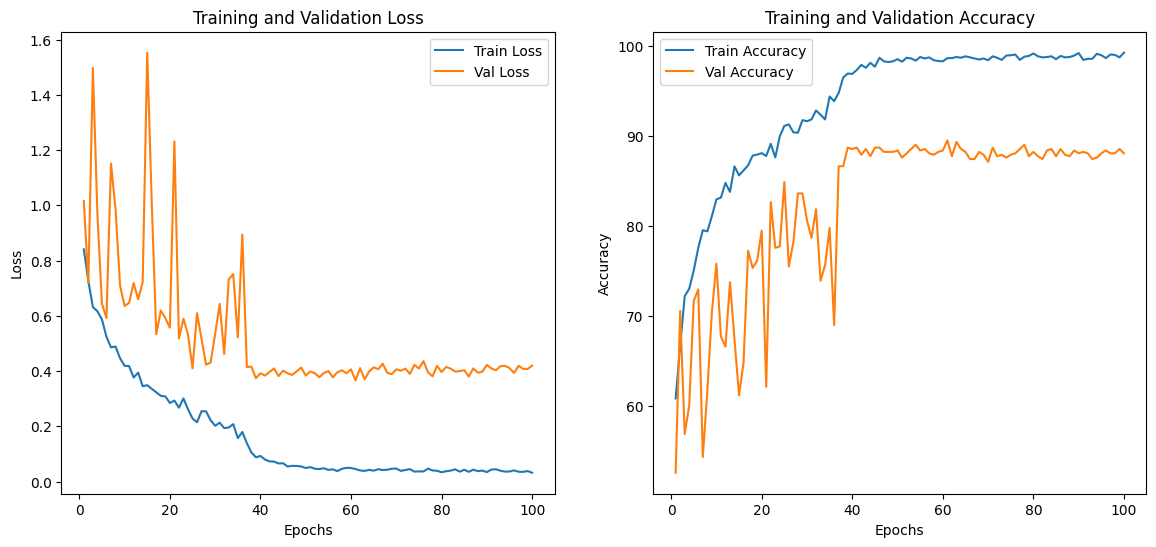

Test Accuracy: 89.63%
              precision    recall  f1-score   support

     Class 0       0.78      0.94      0.85       118
     Class 1       0.91      0.96      0.93       187
     Class 2       0.95      0.84      0.89       322

    accuracy                           0.90       627
   macro avg       0.88      0.91      0.89       627
weighted avg       0.90      0.90      0.90       627



In [ ]:

# Plotting training and validation losses and accuracies
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

# Test the model
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Evaluate the model on the test set
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted)
        true_labels.extend(labels)

# Generate classification report
true_labels = torch.tensor(true_labels).cpu().numpy()
predictions = torch.tensor(predictions).cpu().numpy()
report = classification_report(true_labels, predictions, target_names=[f"Class {i}" for i in range(num_classes)])
print(report)


In [ ]:

from sklearn.metrics import confusion_matrix, balanced_accuracy_score, precision_recall_fscore_support
import numpy as np

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Calculate True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN) for each class
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (FP + FN + TP)

# Calculate metrics for each class
accuracy = np.sum(TP) / np.sum(cm)
balanced_accuracy = balanced_accuracy_score(true_labels, predictions)
recall = TP / (TP + FN)
precision = TP / (TP + FP)
f1_score = 2 * (precision * recall) / (precision + recall)

# Macro-averaged metrics
macro_recall = recall.mean()
macro_precision = precision.mean()
macro_f1_score = f1_score.mean()

# Print confusion matrix and metrics
print("Confusion Matrix:")
print(cm)
print("\nClass-wise Metrics:")
for i in range(len(TP)):
    print(f"Class {i}:")
    print(f"  TP: {TP[i]}")
    print(f"  TN: {TN[i]}")
    print(f"  FP: {FP[i]}")
    print(f"  FN: {FN[i]}")
    print(f"  Recall: {recall[i]:.3f}")
    print(f"  Precision: {precision[i]:.3f}")
    print(f"  F1-score: {f1_score[i]:.3f}")

# Print macro-averaged metrics
print("\nMacro-averaged Metrics:")
print(f"Macro Recall: {macro_recall:.3f}")
print(f"Macro Precision: {macro_precision:.3f}")
print(f"Macro F1-score: {macro_f1_score:.3f}")
print(f"Accuracy (ACC): {accuracy:.3f}")
print(f"Balanced Accuracy (BCC): {balanced_accuracy:.3f}")


Confusion Matrix:
[[111   0   7]
 [  0 179   8]
 [ 32  18 272]]

Class-wise Metrics:
Class 0:
  TP: 111
  TN: 477
  FP: 32
  FN: 7
  Recall: 0.941
  Precision: 0.776
  F1-score: 0.851
Class 1:
  TP: 179
  TN: 422
  FP: 18
  FN: 8
  Recall: 0.957
  Precision: 0.909
  F1-score: 0.932
Class 2:
  TP: 272
  TN: 290
  FP: 15
  FN: 50
  Recall: 0.845
  Precision: 0.948
  F1-score: 0.893

Macro-averaged Metrics:
Macro Recall: 0.914
Macro Precision: 0.878
Macro F1-score: 0.892
Accuracy (ACC): 0.896
Balanced Accuracy (BCC): 0.914
